## Political Interest Project

The premise of this project will involve quantitatively measuring what political topics people care about by state. However, before I can measure what people care about, I need to figure out what data I could use that's readily available on the web.

I ended up scraping local ballot data from [ballotpedia.org](https://ballotpedia.org/Florida_2016_ballot_measures)  by year for Florida. Note, using the function I built below, we could consider this for any state by simply making a list of states and looping through each state

### Scrape the ballot data from ballotpedia.org

In [146]:
import bs4
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup

import pandas as pd

I built the function below in order to scrape ballot data from [ballotpedia.org](https://ballotpedia.org/Florida_2016_ballot_measures). I had to toy around with website's html for a bit. Notice I consider the class "bptable" this contains all of the ballot tables(whether on or not included in the ballot). I had to then consider the td tags and then manipulate the final dataframe to match up the rows with the correct value using mod

In [147]:
#get the parsed blue tables from ballotpedia
def get_ballot_data(state,year):
    containers=soup(uReq('https://ballotpedia.org/{}_{}_ballot_measures'.format(state,year)).read(),'html.parser').findAll("table",{"class":"bptable blue"})
    objects=[]
    for i in range(0,len(containers)):
        for j in range(0,len(containers[i].findAll('td'))):
            objects.append([item for item in containers[i].findAll('td')[j].findAll(text=True) if item != ' '][0])
    first=[]
    second=[]
    third=[]
    fourth=[]
    for j in [i for i in range(0,len(objects)) if i%5 == 0]:
        first.append(objects[j])
    for j in [i for i in range(0,len(objects)) if i%5 == 1]:
        second.append(objects[j])
    for j in [i for i in range(0,len(objects)) if i%5 == 2]:
        third.append(objects[j])
    for j in [i for i in range(0,len(objects)) if i%5 == 3]:
        fourth.append(objects[j])
    df=pd.DataFrame({'Type': first,'Title': second,'Subject': third,'Description':fourth})
    return df

So let's run this scraper for Floria's 2014 ballot data and compare the results with [https://ballotpedia.org/Florida_2014_ballot_measures](https://ballotpedia.org/Florida_2014_ballot_measures) to make sure they're consistent

In [148]:
get_ballot_data('Florida','2014')

,Type,Title,Subject,Description
0,CICA,Amendment 1,Environment,Provides funding for the Land Acquisition Tr...
1,CICA,Amendment 2,Marijuana,Grants the right to use marijuana for the tre...
2,LRCA,Amendment 3,Judiciary,Allows the governor to fill judicial vacancie...
3,CICA,Same-Sex Marriage Amendment,Marriage,Defines marriage as a union of two persons
4,LRCA,Legislative Referral Limit Amendment,Direct democracy,Limits the number of legislative referrals to...
5,LRCA,Renewable Energy Tax Exemption Amendment,Taxes,Revises the legislature’s ability to exempt t...
6,LRCA,Lieutenant Government as Executive Department ...,State executive official,Requires the governor to assign the lieutenan...
7,LRCA,Municipal Property Tax Exemption Amendment,Taxes,Permits the legislature to exempt from taxati...
8,LRCA,Legislative Term Lengths and Limits Amendment,Terms,Increases the term lengths and limits for sta...


If we want to consider all the ballot data from 2012-2017, all we have to do is loop through a list from 2012-2017 using the function above

In [149]:
years=list(range(2012,2018))

In [150]:
Florida=pd.DataFrame()
for i in years:
    try:
        year=get_ballot_data('Florida','{}'.format(i))
        year['year']=str(i)
        Florida=pd.concat([Florida,year],axis=0).reset_index(drop=True)
    except:
        pass
    

In [151]:
Florida.head()

,Type,Title,Subject,Description,year
0,LRCA,Amendment 1,Healthcare,Prevents penalties for not purchasing healthc...,2012
1,LRCA,Amendment 2,Taxes,Allows for property tax discounts for disable...,2012
2,LRCA,Amendment 3,State budgets,Replaces existing revenue limits with a new l...,2012
3,LRCA,Amendment 4,Taxes,Amends commercial and non-homestead property ...,2012
4,LRCA,Amendment 5,Judicial reform,Gives the Legislature increased control over ...,2012


### Find the most important topics using the ballots descriptions

Now that we have all of the local ballot data for Florida from years 2012-2017, we'll want to evaluate which topics are important for Florida. One way to do the is to groupby count as far as **subject**. However, I find the **subject** column to be pretty broad. Another approach we can take is to figure out the important topics using the **description** column. The way I'll measure importance from that column is to measure it's __n-grams__

In [13]:
import nltk
from nltk.util import ngrams 
from pylab import *
from nltk.corpus import stopwords
import re

First we'll want to exclude common words in the english such as "the","was", "can","there",etc. 

In [17]:
X = Florida['Description']
stop = set(stopwords.words('english'))

In [18]:
wordsX = []
for i in X:
    words = i.split()
    wordsX.extend([word for word in words if word not in stop ])

The function below is used to plot the n-gram counts

In [45]:
def plot_ngram(sorted_ngram,ngram_type):
    count = 0
    xaxis = []
    yaxis = []
    for k,v in sorted_ngram:
        yaxis.append(k)
        xaxis.append(v)
        count +=1
        if count == 25:
            break

    figure(1)
    y = arange(25) + 0.5
    barh(y, xaxis,  align = 'center')
    yticks(y, yaxis)
    ylabel('25 Most frequent words')
    xlabel('{} Counts'.format(ngram_type))
    show()

#### Unigram

In [23]:
unigrams_fd = nltk.FreqDist()

unigram_words = wordsX
unigrams_fd.update(unigram_words)

In [24]:
sorted_unigram = sorted(unigrams_fd.items(), reverse = True, key=lambda x: x[1])

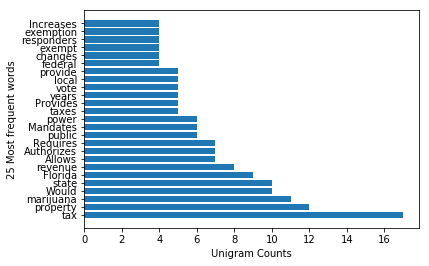

In [46]:
plot_ngram(sorted_unigram,'Unigram')

#### Bigram 

In [33]:
bigrams_fd = nltk.FreqDist()
bigram_words = [ ','.join(map(str,bg)) for bg in nltk.bigrams(wordsX) ]
bigrams_fd.update(bigram_words)


In [35]:
sorted_bigram = sorted(bigrams_fd.items(), reverse = True, key=lambda x: x[1])

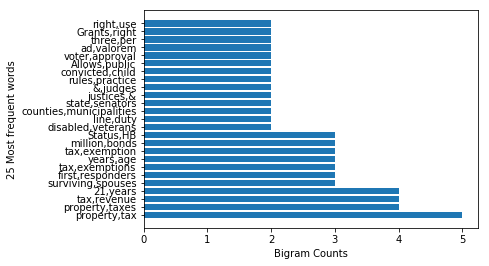

In [47]:
plot_ngram(sorted_bigram,'Bigram')

#### Trigram

In [48]:
trigrams_fd = nltk.FreqDist()
trigram_words = [ ','.join(map(str,tg)) for tg in nltk.trigrams(wordsX) ]
trigrams_fd.update(trigram_words)


In [49]:
sorted_trigram = sorted(trigrams_fd.items(), reverse = True, key=lambda x: x[1])


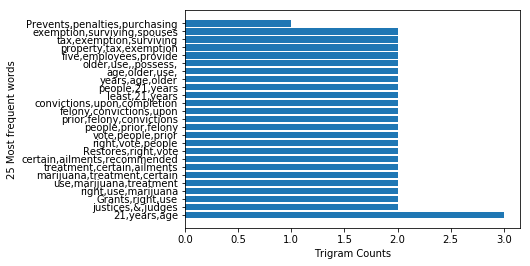

In [50]:
plot_ngram(sorted_trigram,'Trigram')

Looking at the charts from above we can see that Florida really cares about marijuana, property taxes,tax exemptions, convicted felon rights,etc.

 Now that we have the topics that people care about in Florida we could expand this analysis to consider:
 1. Which cities care about this the most. We could represent this via google maps
 2. Whether each topic is positive or negative. For instance, we now know that people care about Marijuana, but are Floridians for or against Marijuana
 
 
 Both 1.) and 2.) can be answered using twitter data. For 2.) we could scrape all tweets involving "Marijuana", do sentiment analysis(1=good,0=neutral,-1=bad) and take the average score. For now I will focus on addressing step 1.)
        

## Scraping Tweets

Below are functions I built to get objects such as the user of the tweet,the user's location and the tweet itself. Note that twitter API has several limitations that I needed to adhere to(such as 1500 tweets per 15 minutes and the fact that I can only scrape a weeks worth of tweets). For simiplicity, I will consider the first 1500 tweets and exclude ant retweets

In [95]:
import tweepy
from textblob import TextBlob
import csv
import time

In [96]:
consumer_key = '' 
consumer_secret = ''

access_token = ''
access_token_secret = ''

In [97]:
#lets authenticate with Twitter which means login via code
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

let's test to make sure the connection to the API is not broken

In [98]:
try:
    api
    print("Twitter API connection already set.")
except NameError:
    api = tweepy.API(auth)
    print("Setting Twitter API connection.")

Twitter API connection already set.


In [99]:
tweet_set = tweepy.Cursor(api.search, 
                    q="Marijuana", 
                    since="2018-07-23", 
                    until="2018-07-30", 
                    #this is a 503km around FL, however it does contain some of Georgia as well
                    # I used this tool: https://www.freemaptools.com/radius-around-point.htm to get the 
                    geocode="27.30228210778564,-84.66796964406967,503km",
                    lang="en").items()

In [7]:
def getElements(tweet):
    user = tweet.get('user').get('screen_name')
    txt = tweet.get('text')
    dt = tweet.get('created_at')
    user_location=tweet.get('user').get('location')
    return user, txt, dt,user_location


In [10]:
i = 0
tweets=pd.DataFrame()
for tweet in tweet_set:
    i +=1
    if (i%1500 != 0):
        user, txt, dt, user_location= getElements(tweet._json)
        table=pd.DataFrame({'user': user,'txt': txt,'dt': dt,'user_location':[user_location]})
        tweets=pd.concat([tweets,table],0).reset_index(drop=True)
    else:
        break
        #time.sleep(60*15)

In [154]:
tweets.head()

,user,txt,dt,user_location
0,bobbyi2000,@LGG94104439 @NYPostOpinion I feel the governm...,Sun Jul 29 23:54:36 +0000 2018,"Palm City, FL"
1,TrumpisSatan1,"RT @thomaskaine5: Beto O'Rourke, independent m...",Sun Jul 29 23:50:05 +0000 2018,Outside the Trump Nazi Reich
2,cathipatpersist,"RT @thomaskaine5: Beto O'Rourke, independent m...",Sun Jul 29 23:48:53 +0000 2018,Texas...thankfully a blue part
3,CaronTreatment,#Marijuana-related emergency room visits for b...,Sun Jul 29 23:45:01 +0000 2018,"PA, FL"
4,FreddaLMartinez,RT @Florida_MJ: Oklahoma Voters Legalize Marij...,Sun Jul 29 23:41:50 +0000 2018,"Albuquerque, NM"


In [14]:
tweets.to_csv('tweets.csv')

## Plot of tweets

Now that we have a sample of 1500 tweets containing the word "Marijuana" in them, let's see where this topic is tweeted the most. First,let's geocode the city names to lat lon points. I'm going to use the mapbox geocoder since it allows me to geocode 50,000 points per month

In [3]:
import pandas as pd
tweets=pd.read_csv('tweets.csv')

In [4]:
from mapbox import Geocoder
import numpy as np

In [5]:
geocoder = Geocoder(access_token='')

In [32]:
lat=[]
lon=[]
for i in range(0,len(tweets)):
    try:
        lat.append(geocoder.forward(tweets['user_location'].iloc[i]).geojson()['features'][0]['center'][1])
        lon.append(geocoder.forward(tweets['user_location'].iloc[i]).geojson()['features'][0]['center'][0])
    except:
        lat.append(np.nan)
        lon.append(np.nan)

In [64]:
#list(zip(lon, lat))
lat=[x for x in lat if str(x) != 'nan']
lon=[x for x in lon if str(x) != 'nan']

In [165]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
from bokeh.io import output_notebook


#output_file("gmap.html")
output_notebook()
#27.6648, -81.5158
map_options = GMapOptions(lat=27.6648, lng=-81.5158, map_type="roadmap", zoom=7)



p = gmap('', map_options, title="Florida")

source = ColumnDataSource(
    data=dict(lat=new_lat,
              lon=new_lon))

p.circle(x="lon", y="lat", size=8, fill_color="blue", fill_alpha=0.8, source=source)
show(p)


Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

Populating the interactive namespace from numpy and matplotlib


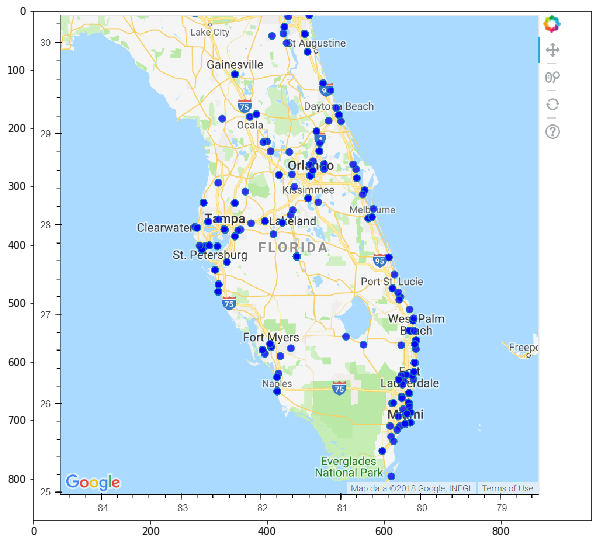

In [167]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
img=mpimg.imread('map.png')
imgplot = plt.imshow(img)
plt.show()

Unfortunately, bokeh does not easily render via Github, so I screen shot the bokeh map. The above illustration shows the location of tweets containing the words "Marijuana". Note that one of the problems with using tweets is it's exposure(in other words, not everyone uses twitter). Moreover the map above does not account for population density. Nonetheless, it shows a good snapshot of where twitter users are talking about "Marijuana". The next part of thie analysis would involve doing sentiment analysis to get an average score of the sentiment for Marijuana. This would give us a good proxy for whether or not the majority of Floridians are for or against Marijuana